In [2]:
'''
If you are using Google Colab, uncomment the next line to download `svm.py`
You can open and change downloaded `.py` files in Colab using the "Files" sidebar on the left.
'''
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/assignment0_03_SVM/svm.py 

--2021-10-24 17:17:51--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/assignment0_03_SVM/svm.py
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 4156 (4,1K) [text/plain]
Сохранение в: «svm.py»

svm.py              100%[===================>]   4,06K  --.-KB/s    за 0s      

2021-10-24 17:17:51 (11,3 MB/s) - «svm.py» сохранён [4156/4156]



In [4]:
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
import numpy as np
from sklearn.metrics import accuracy_score

In [5]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for our SVM class"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.predict(xy).reshape(X.shape)
    # plot decision boundary and margins
    CS = ax.contourf(X, Y, P, origin='lower', cmap='autumn', alpha=0.1)
    plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [6]:
from sklearn.datasets import make_circles

from sklearn.svm import SVC # "Support vector classifier"

X, y = make_circles(150, factor=.1, noise=.1, random_state=42)

X_test, y_test = X[100:], y[100:]
X, y = X[:100], y[:100]

Test accuracy:  0.64


<ipython-input-5-90afdff63472>:15: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')


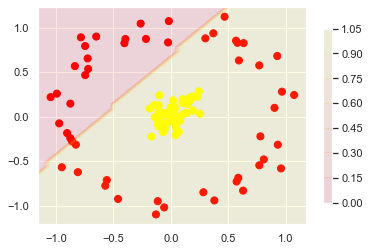

In [7]:
clf = SVC(kernel='linear').fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Test accuracy:  1.0


<ipython-input-5-90afdff63472>:15: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')


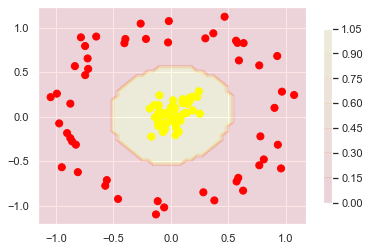

In [8]:
clf = SVC(kernel='rbf').fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [230]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


def rbf(x_1, x_2, sigma=1.):
    '''Computes rbf kernel for batches of objects

    Args:
        x_1: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
        x_2: torch.tensor shaped `(#samples_2, #features)` of type torch.float32
    Returns:
        kernel function values for all pairs of samples from x_1 and x_2
        torch.tensor of type torch.float32 shaped `(#samples_1, #samples_2)`
    '''
    x_1_norm = torch.sum(x_1 ** 2, axis = -1)
    x_2_norm = torch.sum(x_2 ** 2, axis = -1)
    distances = np.exp(- (x_1_norm[:,None] + x_2_norm[None,:] - 2 * np.dot(x_1, x_2.T)))
    return torch.Tensor(distances).type(torch.float32)

def hinge_loss(scores, labels):
    '''Mean loss for batch of objects
    '''
    assert len(scores.shape) == 1
    assert len(labels.shape) == 1
    return torch.clamp(1 - scores * labels, min=0).mean()### YOUR CODE HERE


class SVM(BaseEstimator, ClassifierMixin):
    @staticmethod
    def linear(x_1, x_2):
        '''Computes linear kernel for batches of objects
        
        Args:
            x_1: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
            x_2: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
        Returns:
            kernel function values for all pairs of samples from x_1 and x_2
            torch.tensor shaped `(#samples_1, #samples_2)` of type torch.float32
        '''
        return x_1 @ x_2.T
    
    def __init__(
        self,
        lr: float=1e-3,
        epochs: int=2,
        batch_size: int=64,
        lmbd: float=1e-4,
        kernel_function=None,
        verbose: bool=False,
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbd = lmbd
        self.kernel_function = kernel_function or SVM.linear
        self.verbose = verbose
        self.fitted = False

    def __repr__(self):
        return 'SVM model, fitted: {self.fitted}'

    def fit(self, X, Y):
        assert (np.abs(Y) == 1).all()
        n_obj = len(X)
        X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)
        K = self.kernel_function(X, X).float()
        self.betas = torch.full((n_obj, 1), fill_value=0.001, dtype=X.dtype, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True) # I've also add bias to the model
        
        optimizer = optim.SGD((self.betas, self.bias), lr=self.lr)
        for epoch in range(self.epochs):
            perm = torch.randperm(n_obj)  # Generate a set of random numbers of length: sample size
            sum_loss = 0.                 # Loss for each epoch
            for i in range(0, n_obj, self.batch_size):
                batch_inds = perm[i:i + self.batch_size]
                x_batch = X[batch_inds]   # Pick random samples by iterating over random permutation
                y_batch = Y[batch_inds]   # Pick the correlating class
                k_batch = K[batch_inds]
                
                optimizer.zero_grad()     # Manually zero the gradient buffers of the optimizer
                
                preds = k_batch @ self.betas + self.bias### YOUR CODE HERE # get the matrix product using SVM parameters: self.betas and self.bias
                preds = preds.flatten()
                loss = self.lmbd * self.betas[batch_inds].T @ k_batch @ self.betas + hinge_loss(preds, y_batch)
                loss.backward()           # Backpropagation
                optimizer.step()          # Optimize and adjust weights

                sum_loss += loss.item()   # Add the loss

            if self.verbose: print("Epoch " + str(epoch) + ", Loss: " + str(sum_loss / self.batch_size))

        self.X = X
        self.fitted = True
        return self

    def predict_scores(self, batch):
        with torch.no_grad():
            batch = torch.from_numpy(batch).float()
            K = self.kernel_function(batch, self.X)
            # compute the margin values for every object in the batch
            return (K @ self.betas + self.bias).flatten() ### YOUR CODE HERE

    def predict(self, batch):
        scores = self.predict_scores(batch)
        answers = np.full(len(batch), -1, dtype=np.int64)
        answers[scores > 0] = 1
        return answers

In [231]:
y[y==0] = -1 # for convenience with formulas
y_test[y_test==0] = -1

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 100])
Epoch 0, Loss: 0.2686082124710083
Epoch 1, Loss: 0.4055333137512207
Epoch 2, Loss: 0.3655168652534485
torch.Size([50, 2])
torch.Size([100, 2])
torch.Size([50, 100])
Test accuracy:  0.66
torch.Size([2500, 2])
torch.Size([100, 2])
torch.Size([2500, 100])


<ipython-input-5-90afdff63472>:15: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')


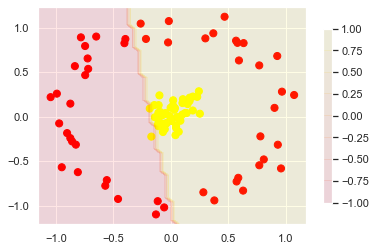

In [232]:
clf = SVM(epochs=3, lr=1, batch_size=20, verbose=True)
clf.fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

start torch.Size([100, 2])
start torch.Size([100, 2])
start torch.Size([100, 100])
Epoch 0, Loss: 0.20847325026988983
Epoch 1, Loss: 0.15057969093322754
Epoch 2, Loss: 0.12260791659355164
Epoch 3, Loss: 0.09517053961753845
Epoch 4, Loss: 0.05084618255496025
Epoch 5, Loss: 0.07730702906847
Epoch 6, Loss: 0.017835342837497593
Epoch 7, Loss: 0.003029204497579485
Epoch 8, Loss: 0.002879871653567534
Epoch 9, Loss: 0.0015711654836195522
Epoch 10, Loss: 0.0015213884995318948
Epoch 11, Loss: 0.0012938515079440548
Epoch 12, Loss: 0.001187625661259517
Epoch 13, Loss: 0.0013401848293142394
Epoch 14, Loss: 0.0012334549261140636
Epoch 15, Loss: 0.0006834798463387415
Epoch 16, Loss: 0.0017702389493933878
Epoch 17, Loss: 0.000970116798998788
Epoch 18, Loss: 0.0013013194606173784
Epoch 19, Loss: 0.0008150501758791507
Epoch 20, Loss: 0.0009191947538056411
Epoch 21, Loss: 0.0016374119746615178
Epoch 22, Loss: 0.0007631698608747683
Epoch 23, Loss: 0.0009846330896834843
Epoch 24, Loss: 0.00066345285013085

<ipython-input-5-90afdff63472>:15: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')


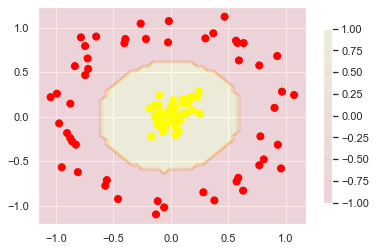

In [233]:
clf = SVM(epochs=100, lr=0.1, batch_size=20, verbose=True, kernel_function=rbf)
clf.fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [224]:
import numpy
a = numpy.array([[2,3],[3,5]])
b = numpy.array([[3,2]])
print(a.shape)
print(b.shape)
np.sum(a ** 2, axis = -1)

(2, 2)
(1, 2)


array([13, 34])

In [167]:
distances = np.exp(- ((X**2 + X**2 - 2*X.dot(X.T)) / (2*1**2)))

ValueError: operands could not be broadcast together with shapes (100,2) (100,100) 

In [225]:
X= torch.FloatTensor(X)
X_norm = torch.sum(X ** 2, axis = -1)
K = np.exp(- (X_norm + X_norm - 2 * np.dot(X, X.T)))
print(K.shape)
print(X_norm[:,None].shape)
print(X_norm[None,:].shape)

print((X_norm[:,None] + X_norm[None,:]).shape)

torch.Size([100, 100])
torch.Size([100, 1])
torch.Size([1, 100])
torch.Size([100, 100])
